In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
AUTOTUNE = tf.data.AUTOTUNE
from tqdm import tqdm

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os 

In [2]:
def flip_left_right(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))

def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)

def random_crop(lr_img, hr_img, hr_crop_size=96, scale=4):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_width = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_height = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_width = lr_width * scale
    hr_height = lr_height * scale

    lr_img_cropped = lr_img[lr_height:lr_height + lr_crop_size, lr_width:lr_width + lr_crop_size]
    hr_img_cropped = hr_img[hr_height:hr_height + hr_crop_size, hr_width:hr_width + hr_crop_size]

    return lr_img_cropped, hr_img_cropped

In [3]:
div2k_data = tfds.image.Div2k(config='bicubic_x4')
div2k_data.download_and_prepare()

2022-01-22 15:44:34.307492: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling div2k-train.tfrecord...:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling div2k-validation.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


In [4]:
train = div2k_data.as_dataset(split='train',as_supervised=True)
train_cache = train.cache()

2022-01-22 15:50:08.383767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 15:50:08.776466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 15:50:08.777327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 15:50:08.781642: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
ds = train_cache

ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=4),num_parallel_calls=AUTOTUNE)
ds = ds.map(random_rotate,num_parallel_calls=AUTOTUNE)
ds = ds.map(flip_left_right,num_parallel_calls=AUTOTUNE)

ds = ds.batch(16)
ds = ds.repeat(None)
ds = ds.prefetch(buffer_size=AUTOTUNE)

In [6]:
def normalize(x):
    return x / 255.0

def normalize2(x):
    return x / 127.5 - 1

def denormalize2(x):
    return (x + 1) * 127.5

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [7]:
def Upsampling(inputs):
    x = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same')(inputs)
    x = tf.keras.layers.Lambda(pixel_shuffle(scale=2))(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)
    return x

def ResBlock(inputs):
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tf.keras.layers.Add()([inputs, x])
    return x

def SRResNet_Generator(num_filters=64):
    input_layer = tf.keras.layers.Input(shape=(None, None, 3))
    x = tf.keras.layers.Lambda(normalize)(input_layer)
    x = tf.keras.layers.Conv2D(64, kernel_size=9, padding='same')(x)
    x = x_new = tf.keras.layers.PReLU(shared_axes=[1, 2])(x)

    for _ in range(16):
        x = ResBlock(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x_new, x])

    x = Upsampling(x)
    x = Upsampling(x)

    x = tf.keras.layers.Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    output_layer = tf.keras.layers.Lambda(denormalize2)(x)

    return tf.keras.models.Model(input_layer, output_layer)


SRResNet = SRResNet_Generator()

In [8]:
loss_fn = tf.keras.losses.MeanSquaredError()
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [9]:
@tf.function
def train_step(ds_low, ds_high):
    with tf.GradientTape() as SRResNet_tape:
        
        ds_low = tf.cast(ds_low, tf.float32)
        ds_high = tf.cast(ds_high, tf.float32)

        sr = SRResNet(ds_low)
        loss_value = loss_fn(ds_high, sr)

    gradients = SRResNet_tape.gradient(loss_value, SRResNet.trainable_variables)
    optim.apply_gradients(zip(gradients, SRResNet.trainable_variables))

    return loss_value

In [10]:
for epoch in range(200):

    for lr, hr in ds.take(1000):
        loss_value = train_step(lr, hr)

    if epoch % 10 == 0 or epoch == 199:
        print(f'Epochs : {epoch}   ||   Loss : {loss_value:.5f}')

2022-01-22 15:50:13.275676: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-22 15:50:42.450917: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Epochs : 0   ||   Loss : 289.31299
Epochs : 10   ||   Loss : 114.27618
Epochs : 20   ||   Loss : 85.83622
Epochs : 30   ||   Loss : 240.04485
Epochs : 40   ||   Loss : 147.47614
Epochs : 50   ||   Loss : 59.57493
Epochs : 60   ||   Loss : 68.38559
Epochs : 70   ||   Loss : 64.54693
Epochs : 80   ||   Loss : 104.30305
Epochs : 90   ||   Loss : 108.08525
Epochs : 100   ||   Loss : 150.73782
Epochs : 110   ||   Loss : 43.40099
Epochs : 120   ||   Loss : 80.36501
Epochs : 130   ||   Loss : 46.84075
Epochs : 140   ||   Loss : 114.37195
Epochs : 150   ||   Loss : 66.11660
Epochs : 160   ||   Loss : 132.73221
Epochs : 170   ||   Loss : 100.05141
Epochs : 180   ||   Loss : 150.28636
Epochs : 190   ||   Loss : 70.67714
Epochs : 199   ||   Loss : 114.82629


In [11]:
!mkdir saved_model
SRResNet.save('/kaggle/working/saved_model',save_format='tf')
SRResNet.save("/kaggle/working/saved_model/model.h5")

2022-01-22 17:45:37.104774: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [12]:
def Predict(model, img):
    sr = model(tf.cast(tf.expand_dims(img, axis=0), tf.float32))
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.squeeze(tf.cast(sr, tf.uint8),axis=0)
    return sr

def load_img(path):
    img = np.array(Image.open(path))
    return img

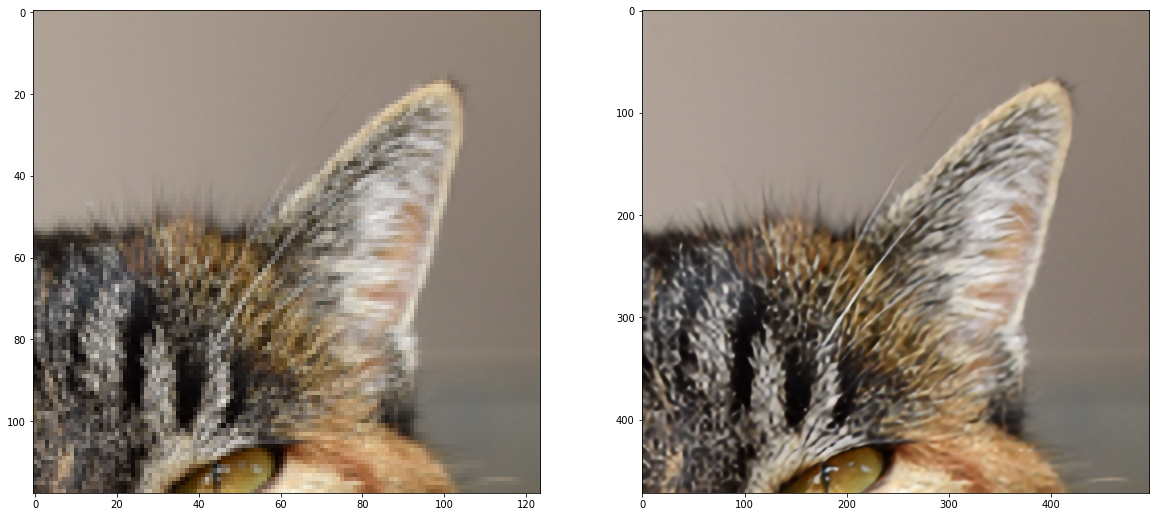

In [13]:
img = load_img("../input/cat-and-bug/cat.png")
pred = Predict(SRResNet, img)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(pred)
plt.show()